In [1]:
using POMDPs
using POMDPTools
using QuickPOMDPs
using MCTS
using POMDPSimulators
using Distributions
using LinearAlgebra
using D3Trees
using Random
using Plots
using CSV
using DataFrames
using Tables

# Parameters

In [2]:
# Dimensions
max_progress = 10
max_power = 50
max_h2o = 50
max_o2 = 50
max_food = 50

# Uncertainties
p_mission_regression = 0.05
p_power_fail = 0.02
p_water_loss = 0.02
p_food_loss = 0.02
p_no_mission_progress = 0.05

# Resource consumption
consumed_power = -2 # generated
consumed_h2o = 1
consumed_o2 = 1
consumed_food = 1

1

In [3]:
# Define all possible states and actions (with constraints)
# [progress, power, h2o, o2, food]
indexed = LinearIndices((max_progress, max_power, max_h2o, max_o2, max_food))
states = 1:indexed[max_progress, max_power, max_h2o, max_o2, max_food]

basic_actions = [
      CartesianIndex(1, -3, 0, 0, 0), # make mission progress
      CartesianIndex(0, -1, 8, 0, 0), # make water 
      CartesianIndex(0, -1, -1, 7, 0), # make oxygen
      CartesianIndex(0, -1, -1, -1, 6), # make food
      CartesianIndex(0, 0, 0, 0, 0) # do nothing
] 
consumed = CartesianIndex(0, consumed_power, consumed_h2o, consumed_o2, consumed_food)
actions = [action - consumed for action in basic_actions]

5-element Vector{CartesianIndex{5}}:
 CartesianIndex(1, -1, -1, -1, -1)
 CartesianIndex(0, 1, 7, -1, -1)
 CartesianIndex(0, 1, -2, 6, -1)
 CartesianIndex(0, 1, -2, -2, 5)
 CartesianIndex(0, 2, -1, -1, -1)

In [4]:
# Determine if action is out of bounds
# Associated consequences are reflected in transition/reward functions
state_maxes = [max_progress, max_power, max_h2o, max_o2, max_food]
function inbounds(state, action)
    for i in 1:length(state)
        if (state[i] + action[i]) < 1
            return false
        end
    end
    return true
end

function clamp_state(state)
    for i in 1:length(state)
        state[i] = clamp(state[i], 1, state_maxes[i])
    end
    return state
end

function cartesian2linear(svec)
    return indexed[CartesianIndex(Tuple(svec))]
end

function linear2cartesian(s)
    return CartesianIndices((max_progress, max_power, max_h2o, max_o2, max_food))[s]
end


linear2cartesian (generic function with 1 method)

In [5]:
# Is terminal?
function isterminal(s)
    svec = linear2cartesian(s)
    end_state = svec[1] == max_progress # If reached a goal state
    failed = all([any([(svec[i] + a[i]) < 1 for i in 1:length(svec)]) for a in actions]) # If all actions result in negative out of bounds (failed mission)
    return end_state || failed 
end


# Provide a list of valid actions
function valid_actions(svec)
    return [a for a in actions if !any([svec[i] + a[i] < 1 for i in 1:length(svec)])]
end

# Transition function
function transition(s, a)
    p_nominal = 1 - p_no_mission_progress - p_water_loss - p_power_fail - p_mission_regression 
    p = [p_no_mission_progress, p_water_loss, p_power_fail, p_mission_regression, p_nominal]

    svec = collect(Tuple(linear2cartesian(s)))
    a = collect(Tuple(a))
    if !inbounds(svec, a)
        a = collect(Tuple(last(actions))) # Try "do nothing"
        if inbounds(svec, a) # If "do nothing" works
            spvec = svec + a
        else # If "do nothing" is not possible, choose a random action that is valid
            possible_actions = valid_actions(svec)
            a = collect(Tuple(rand(possible_actions)))
            spvec = svec + a
        end
        sp = cartesian2linear(clamp_state(spvec))
        return SparseCat([sp,], [1,])
    else
        spvec_no_mission_progress = svec + collect(Tuple(last(actions)))

        spvec_water_loss = svec + a
        spvec_water_loss[3] = round(0.5 * spvec_water_loss[3]) # lose all water

        spvec_power_fail = svec + a
        spvec_power_fail[2] = round(0.5 * spvec_power_fail[2]) # lose all energy

        spvec_mission_regression = svec + a
        spvec_mission_regression[1] = spvec_mission_regression[1] - 1 # mission setback

        spvec_nominal = svec + a

        spvec = [spvec_no_mission_progress, spvec_water_loss, spvec_power_fail, spvec_mission_regression, spvec_nominal]
    end
    
    sp = []
    for i in 1:length(p)
        push!(sp, cartesian2linear(clamp_state(spvec[i])))
    end
    return SparseCat(sp, p)
    
end

# Reward function
function reward(s, a)
    svec = linear2cartesian(s)
    spvec = svec
    if spvec[1] == max_progress
        r = 1000000000000
    elseif !inbounds(svec, a) # If invalid action
        r = -100
    else
        r = -1
    end
    return r
end

reward (generic function with 1 method)

In [6]:
function generate_mdp(initialstate, states=states, actions=actions, discount=0.95, isterminal=isterminal, transition=transition, reward=reward)
    return QuickMDP(
        states = states,
        actions = actions,
        initialstate = initialstate,
        discount = discount,
        isterminal = isterminal,
        transition = transition,
        reward = reward
    )
end

generate_mdp (generic function with 7 methods)

# MCTS Simulation

In [7]:
function simulate_mcts(initialstate, iter, rollout_iter, depth, replan_interval)

    history = []
    sarsp = Imatrix = zeros(Int, 4, 1)

    s = initialstate
    push!(history, s)
    policy = rollout_policy(s, rollout_iter, depth)

    for i in 1:iter

        if isterminal(s)
            break
        end


        if i % replan_interval == 0 # Replan
            policy = rollout_policy(s, rollout_iter, depth )
        end

        a = action(policy, s)
        T = transition(s, a)
        sp = rand(T) 
        r = reward(sp, a)
        a_ind = findfirst(item -> item == a, actions)
        sarsp = hcat(sarsp, [indexed[s], a_ind, r, indexed[sp]])
        push!(history, sp)
        
        s = sp

    end
    sarsp = sarsp[:, 2:end]
    
    return history, sarsp

end

function rollout_policy(state, rollout_iter, depth)
    mdp = generate_mdp(state)
    solver = MCTSSolver(n_iterations=rollout_iter, depth=depth, exploration_constant=1.0, enable_tree_vis=true)
    policy = solve(solver, mdp)
    return policy
end

rollout_policy (generic function with 1 method)

In [8]:
initialstate = indexed[1, 10, 10, 10, 10]

11479591

In [9]:
#simulate a lot of data

# The file is now empty
open("MCTS_policy_sarsp.csv", "w") do file  
end

open("MCTS_policy_steps.csv", "w") do file  
end

for i in 1:100
    initialstate = indexed[1, 10, 10, 10, 10]
    history_var, sarsp = simulate_mcts(initialstate, 100, 1000, 100, 1)
    CSV.write("MCTS_policy_history.csv", Tables.table(history_var), append = true)

    CSV.write("MCTS_policy_sarsp.csv", Tables.table(sarsp'), header = ["s", "a", "r", "s'"], append = true)
end

In [10]:
history_var = [linear2cartesian(s) for s in history_var]

UndefVarError: UndefVarError: `history_var` not defined

In [11]:
history_progress = [s[1] / max_progress for s in history_var]
history_power = [s[2] / max_power for s in history_var]
history_h2o = [s[3] / max_h2o for s in history_var]
history_o2 = [s[4] / max_o2 for s in history_var]
history_food = [s[5] / max_food for s in history_var]

UndefVarError: UndefVarError: `history_var` not defined

In [12]:
p1 = plot()
plot!(
    p1,
    1:length(history_var),
    [history_progress history_power history_h2o history_o2 history_food],
    label=["Progress" "Power" "H2O" "O2" "Food"]
)
hline!(p1, [1], label="Progress Goal")

UndefVarError: UndefVarError: `history_var` not defined

# Random Simulation

In [13]:
# Random action (must be valid, only call when valid action exists)
function random_action(s)
    svec = linear2cartesian(s)
    possible_actions = valid_actions(svec)
    a = rand(possible_actions)
    return a
end

random_action (generic function with 1 method)

In [14]:
function simulate_random(initialstate, iter)
    s = initialstate
    sarsp = Imatrix = zeros(Int, 4, 1)
    history = []
    push!(history, s)
    for _ in 1:iter
        if isterminal(s)
            break
        end
        a = random_action(s) # Choose valid action randomly
        T = transition(s, a)
        sp = rand(T)
        r = reward(sp, a)
        a_ind = findfirst(item -> item == a, actions)
        sarsp = hcat(sarsp, [indexed[s], a_ind, r, indexed[sp]])
        push!(history, sp)
        s = sp
    end

    #delete first row again
    sarsp = sarsp[:, 2:end]
    return history, sarsp
end

simulate_random (generic function with 1 method)

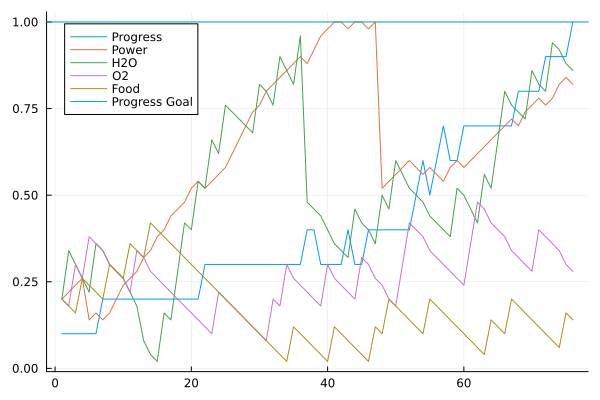

In [15]:
rand_history, sarsp = simulate_random(initialstate, 100)
rand_history = [linear2cartesian(s) for s in rand_history]
rand_history_progress = [s[1] / max_progress for s in rand_history]
rand_history_power = [s[2] / max_power for s in rand_history]
rand_history_h2o = [s[3] / max_h2o for s in rand_history]
rand_history_o2 = [s[4] / max_o2 for s in rand_history]
rand_history_food = [s[5] / max_food for s in rand_history]
p2 = plot()
plot!(
    p2,
    1:length(rand_history),
    [rand_history_progress rand_history_power rand_history_h2o rand_history_o2 rand_history_food],
    label=["Progress" "Power" "H2O" "O2" "Food"]
)
hline!(p2, [1], label="Progress Goal")

In [16]:
steps = []
for i in 1:100
    rand_history, sarsp = simulate_random(initialstate, 100)
    rand_history = [linear2cartesian(s) for s in rand_history]
    rand_history_progress = [s[1] / max_progress for s in rand_history]
    if (rand_history_progress[end] != 1)
        push!(steps, 0)
    else
        push!(steps, length(rand_history))
    end
end

CSV.write("random_policy.csv", Tables.table(steps), append = false)


"random_policy.csv"

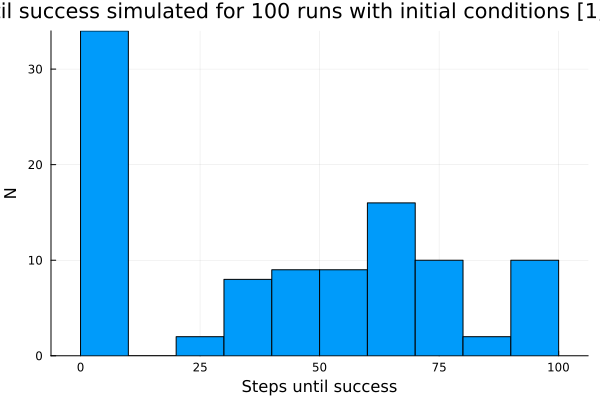

In [17]:
df = CSV.read("random_policy.csv", DataFrame)
Data = Matrix(df)
histogram(Data; bins = 0:10:100, label=false, title = "Steps until success simulated for 100 runs with initial conditions [1,10,10,10,10]" )
ylabel!("N")
xlabel!("Steps until success")

In [18]:
#simulate a lot of data


# The file is now empty
open("random_policy_sarsp.csv", "w") do file  
end

for i in 1:10000
    rand_history, sarsp = simulate_random(initialstate, 100)
    rand_history = [linear2cartesian(s) for s in rand_history]
    rand_history_progress = [s[1] / max_progress for s in rand_history]
    if (rand_history_progress[end] != 1)
        push!(steps, 0)
    else
        push!(steps, length(rand_history))
    end
    CSV.write("random_policy_sarsp.csv", Tables.table(sarsp'), header = ["s", "a", "r", "s'"], append = true)
end

